In [ ]:
import math
import numpy as np

第一题

开始参数优化...
正在优化参数...
进度: 1000/26000
进度: 2000/26000
进度: 3000/26000
进度: 4000/26000
进度: 5000/26000
进度: 6000/26000
进度: 7000/26000
进度: 8000/26000
进度: 9000/26000
进度: 10000/26000
进度: 11000/26000
进度: 12000/26000
进度: 13000/26000
进度: 14000/26000
进度: 15000/26000
进度: 16000/26000
进度: 17000/26000
进度: 18000/26000
进度: 19000/26000
进度: 20000/26000
进度: 21000/26000
进度: 22000/26000
进度: 23000/26000
进度: 24000/26000
进度: 25000/26000
进度: 26000/26000

=== 优化结果 ===
最佳颠球次数: 105
队员人数: 8
每人施力: 50.0 N
鼓面下降角度: 30.0°
碰撞时间: 0.030 s
最终高度: 0.401 m


/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_72769/1392196847.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  force_groups = df_results.groupby(pd.cut(df_results['force'], bins=10))['bounces'].max()


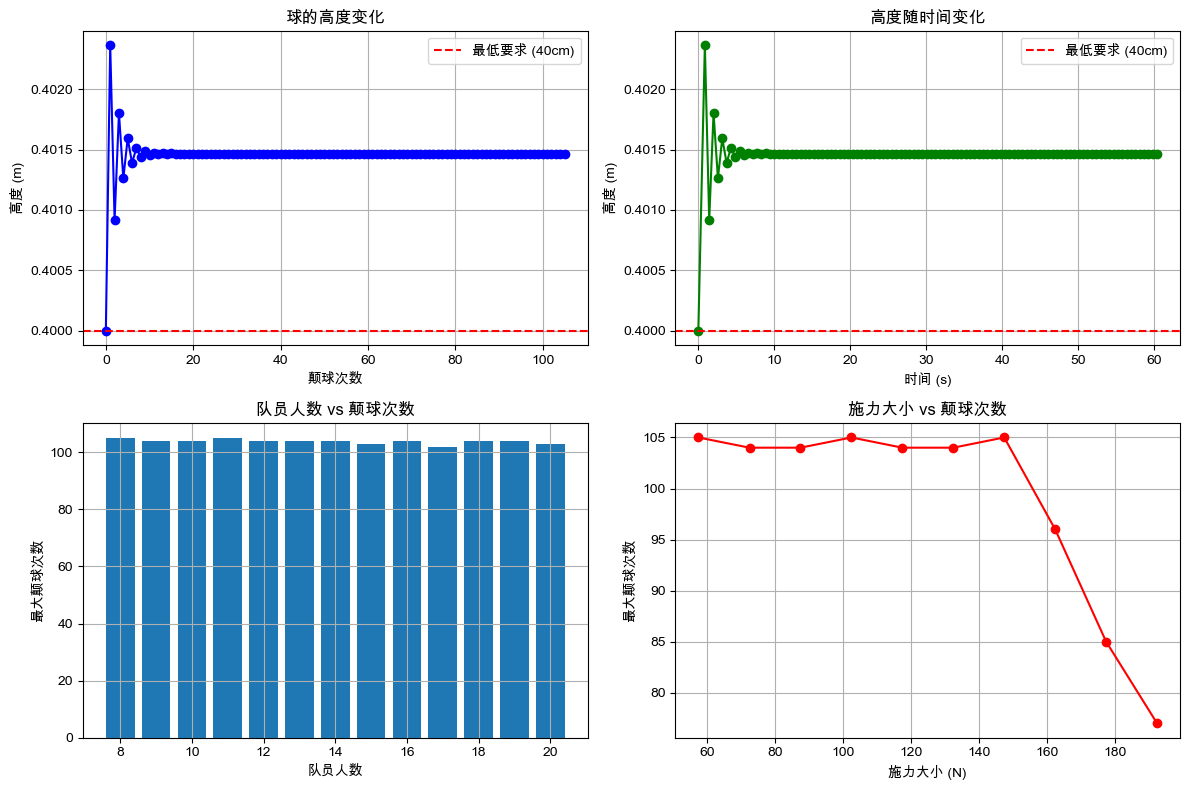


=== 统计信息 ===
总计算组合数: 26000
平均颠球次数: 19.5
最大颠球次数: 105
最优队员人数范围: 8-20

结果已保存到 drum_bouncing_results.csv

=== 前10个最佳策略 ===
105.0次 - 8.0人, 50.0N, 30.0°, 0.030s
105.0次 - 8.0人, 144.7N, 21.7°, 0.010s
105.0次 - 11.0人, 105.3N, 16.1°, 0.010s
104.0次 - 8.0人, 65.8N, 5.0°, 0.020s
104.0次 - 8.0人, 73.7N, 24.4°, 0.020s
104.0次 - 8.0人, 136.8N, 10.6°, 0.010s
104.0次 - 9.0人, 128.9N, 18.9°, 0.010s
104.0次 - 10.0人, 57.9N, 16.1°, 0.020s
104.0次 - 10.0人, 113.2N, 13.3°, 0.010s
104.0次 - 10.0人, 121.1N, 24.4°, 0.010s


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize
import pandas as pd

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class DrumBouncingModel:
    def __init__(self):
        # 物理常数
        self.g = 9.81  # 重力加速度 (m/s^2)
        
        # 项目参数
        self.m_ball = 0.27  # 排球质量 (kg)
        self.m_drum = 3.6   # 鼓的质量 (kg)
        self.drum_diameter = 0.4  # 鼓面直径 (m)
        self.drum_height = 0.22   # 鼓身高度 (m)
        self.h_initial = 0.4      # 初始高度 (m)
        self.h_min = 0.4          # 最小反弹高度 (m)
        self.min_distance = 0.6   # 队员间最小距离 (m)
        self.min_members = 8      # 最少队员数
        
    def calculate_rope_length(self, n_members, distance):
        """
        根据队员数量和间距计算绳长
        使用正弦定理：D/sin(360°/n) = L/sin(90° - 180°/n)
        """
        angle_between = 360 / n_members  # 队员间夹角
        angle_rad = np.radians(angle_between)
        
        # 使用正弦定理计算绳长
        L = distance * np.sin(np.radians(90 - 180/n_members)) / np.sin(angle_rad)
        return L
    
    def drum_height_from_angle(self, L, theta):
        """计算鼓面下降高度"""
        return L * np.sin(np.radians(theta))
    
    def ball_velocity_at_impact(self, h_ball, h_drum):
        """计算球撞击鼓面时的速度"""
        return np.sqrt(2 * self.g * (h_ball + h_drum))
    
    def calculate_collision_dynamics(self, v_ball, F, n_members, collision_time):
        """
        计算碰撞动力学
        假设完全弹性碰撞
        """
        # 鼓面获得的冲量和速度
        impulse = F * n_members * collision_time
        v_drum = impulse / self.m_drum
        
        # 动量守恒和能量守恒
        # 假设完全弹性碰撞
        v_ball_after = ((self.m_ball - self.m_drum) * v_ball + 2 * self.m_drum * v_drum) / (self.m_ball + self.m_drum)
        
        return v_ball_after
    
    def calculate_bounce_height(self, v_ball_after):
        """根据反弹速度计算高度"""
        return v_ball_after**2 / (2 * self.g)
    
    def single_bounce_simulation(self, h_prev, F, n_members, theta, collision_time):
        """模拟单次颠球过程"""
        # 计算绳长
        D = self.min_distance  # 使用最小距离
        L = self.calculate_rope_length(n_members, D)
        
        # 鼓面下降高度
        h_drum = self.drum_height_from_angle(L, theta)
        
        # 球撞击速度
        v_impact = self.ball_velocity_at_impact(h_prev, h_drum)
        
        # 碰撞后速度
        v_after = self.calculate_collision_dynamics(v_impact, F, n_members, collision_time)
        
        # 反弹高度
        h_next = self.calculate_bounce_height(v_after)
        
        return h_next, L, h_drum
    
    def calculate_bounce_time(self, h_prev, h_curr):
        """计算一次完整颠球的时间"""
        t_fall = np.sqrt(2 * h_prev / self.g)
        t_rise = np.sqrt(2 * h_curr / self.g)
        return t_fall + t_rise
    
    def simulate_bouncing_sequence(self, F, n_members, theta, collision_time, max_time=60):
        """模拟连续颠球序列"""
        heights = [self.h_initial]
        times = [0]
        total_time = 0
        
        # 第一次下落时间
        first_fall_time = np.sqrt(2 * self.h_initial / self.g)
        total_time += first_fall_time
        
        bounce_count = 0
        
        while total_time < max_time:
            h_prev = heights[-1]
            
            # 模拟单次颠球
            h_next, L, h_drum = self.single_bounce_simulation(h_prev, F, n_members, theta, collision_time)
            
            # 检查是否满足高度要求
            if h_next < self.h_min:
                break
            
            heights.append(h_next)
            bounce_count += 1
            
            # 计算下一次颠球时间
            bounce_time = self.calculate_bounce_time(h_prev, h_next)
            total_time += bounce_time
            times.append(total_time)
        
        return bounce_count, heights, times
    
    def optimize_parameters(self):
        """优化参数以最大化颠球次数"""
        results = []
        
        # 搜索参数范围
        member_counts = range(8, 21)  # 8-20人
        forces = np.linspace(50, 200, 20)  # 50-200N
        angles = np.linspace(5, 30, 10)   # 5-30度
        collision_times = np.linspace(0.01, 0.1, 10)  # 0.01-0.1秒
        
        best_result = {'bounces': 0, 'params': None}
        
        print("正在优化参数...")
        total_combinations = len(member_counts) * len(forces) * len(angles) * len(collision_times)
        current_combination = 0
        
        for n_members in member_counts:
            for F in forces:
                for theta in angles:
                    for t_collision in collision_times:
                        current_combination += 1
                        if current_combination % 1000 == 0:
                            print(f"进度: {current_combination}/{total_combinations}")
                        
                        try:
                            bounces, heights, times = self.simulate_bouncing_sequence(
                                F, n_members, theta, t_collision
                            )
                            
                            result = {
                                'n_members': n_members,
                                'force': F,
                                'angle': theta,
                                'collision_time': t_collision,
                                'bounces': bounces,
                                'final_height': heights[-1] if heights else 0
                            }
                            results.append(result)
                            
                            if bounces > best_result['bounces']:
                                best_result = {
                                    'bounces': bounces,
                                    'params': result,
                                    'heights': heights,
                                    'times': times
                                }
                                
                        except Exception as e:
                            continue
        
        return results, best_result

# 创建模型实例
model = DrumBouncingModel()

# 运行优化
print("开始参数优化...")
results, best_result = model.optimize_parameters()

# 显示结果
print("\n=== 优化结果 ===")
if best_result['params']:
    params = best_result['params']
    print(f"最佳颠球次数: {params['bounces']}")
    print(f"队员人数: {params['n_members']}")
    print(f"每人施力: {params['force']:.1f} N")
    print(f"鼓面下降角度: {params['angle']:.1f}°")
    print(f"碰撞时间: {params['collision_time']:.3f} s")
    print(f"最终高度: {params['final_height']:.3f} m")
    
    # 绘制高度变化图
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(range(len(best_result['heights'])), best_result['heights'], 'bo-')
    plt.axhline(y=0.4, color='r', linestyle='--', label='最低要求 (40cm)')
    plt.xlabel('颠球次数')
    plt.ylabel('高度 (m)')
    plt.title('球的高度变化')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(best_result['times'], best_result['heights'], 'go-')
    plt.axhline(y=0.4, color='r', linestyle='--', label='最低要求 (40cm)')
    plt.xlabel('时间 (s)')
    plt.ylabel('高度 (m)')
    plt.title('高度随时间变化')
    plt.grid(True)
    plt.legend()
    
    # 参数敏感性分析
    df_results = pd.DataFrame(results)
    
    plt.subplot(2, 2, 3)
    grouped = df_results.groupby('n_members')['bounces'].max()
    plt.bar(grouped.index, grouped.values)
    plt.xlabel('队员人数')
    plt.ylabel('最大颠球次数')
    plt.title('队员人数 vs 颠球次数')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    # 力度与颠球次数的关系
    force_groups = df_results.groupby(pd.cut(df_results['force'], bins=10))['bounces'].max()
    force_centers = [interval.mid for interval in force_groups.index]
    plt.plot(force_centers, force_groups.values, 'ro-')
    plt.xlabel('施力大小 (N)')
    plt.ylabel('最大颠球次数')
    plt.title('施力大小 vs 颠球次数')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 显示统计信息
    print(f"\n=== 统计信息 ===")
    print(f"总计算组合数: {len(results)}")
    print(f"平均颠球次数: {df_results['bounces'].mean():.1f}")
    print(f"最大颠球次数: {df_results['bounces'].max()}")
    print(f"最优队员人数范围: {df_results[df_results['bounces'] >= df_results['bounces'].quantile(0.9)]['n_members'].min()}-{df_results[df_results['bounces'] >= df_results['bounces'].quantile(0.9)]['n_members'].max()}")
    
else:
    print("未找到有效解")

# 保存结果
df_results = pd.DataFrame(results)
df_results.to_csv('drum_bouncing_results.csv', index=False, encoding='utf-8-sig')
print(f"\n结果已保存到 drum_bouncing_results.csv")

# 显示前10个最佳结果
print("\n=== 前10个最佳策略 ===")
top_results = df_results.nlargest(10, 'bounces')
for idx, row in top_results.iterrows():
    print(f"{row['bounces']}次 - {row['n_members']}人, {row['force']:.1f}N, {row['angle']:.1f}°, {row['collision_time']:.3f}s")

第二题

队员角度位置 (度): [  0.  45.  90. 135. 180. 225. 270. 315.]
计算的鼓面倾斜角度结果 (t=0.1s)

【情况 1】
发力时机(s): [0, 0, 0, 0, 0, 0, 0, 0]
发力大小(N): [90, 80, 80, 80, 80, 80, 80, 80]
x轴倾斜角度: 0.336135°
y轴倾斜角度: 0.000000°
总倾斜角度:   0.336135°
------------------------------------------------------------

【情况 2】
发力时机(s): [0, 0, 0, 0, 0, 0, 0, 0]
发力大小(N): [90, 90, 80, 80, 80, 80, 80, 80]
x轴倾斜角度: 0.573819°
y轴倾斜角度: 0.237684°
总倾斜角度:   0.621097°
------------------------------------------------------------

【情况 3】
发力时机(s): [0, 0, 0, 0, 0, 0, 0, 0]
发力大小(N): [90, 80, 80, 90, 80, 80, 80, 80]
x轴倾斜角度: 0.098452°
y轴倾斜角度: 0.237684°
总倾斜角度:   0.257267°
------------------------------------------------------------

【情况 4】
发力时机(s): [-0.1, 0, 0, 0, 0, 0, 0, 0]
发力大小(N): [80, 80, 80, 80, 80, 80, 80, 80]
x轴倾斜角度: -2.689082°
y轴倾斜角度: 0.000000°
总倾斜角度:   2.689082°
------------------------------------------------------------

【情况 5】
发力时机(s): [-0.1, -0.1, 0, 0, 0, 0, 0, 0]
发力大小(N): [80, 80, 80, 80, 80, 80, 80, 80]
x轴倾斜角度: -4.590550°
y轴倾斜角度: -1.9

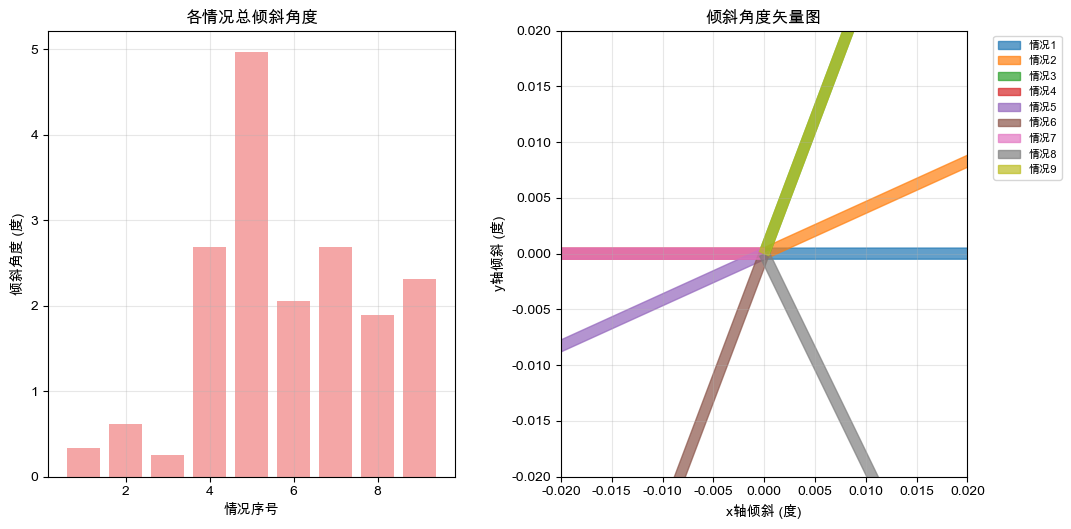

最终结果汇总表
序号   θx(°)        θy(°)        总倾斜(°)      
----------------------------------------------------------------------
1    0.336135     0.000000     0.336135    
2    0.573819     0.237684     0.621097    
3    0.098452     0.237684     0.257267    
4    -2.689082    0.000000     2.689082    
5    -4.590550    -1.901468    4.968775    
6    -0.787614    -1.901468    2.058134    
7    -2.689082    0.000000     2.689082    
8    0.886066     -1.663785    1.885018    
9    0.886066     2.139152     2.315401    


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 物理参数
g = 9.8  # 重力加速度 m/s^2
m_drum = 3.6  # 鼓质量 kg
R_drum = 0.2  # 鼓半径 m (直径40cm)
L_rope = 1.7  # 绳长 m
n_players = 8  # 队员数量
initial_drop = 0.11  # 初始下降 m
delta_t = 0.01  # 发力持续时间 s

# 计算鼓的转动惯量
I_drum = 0.5 * m_drum * R_drum**2


# 队员角度位置 (8个人均匀分布)
theta_positions = np.linspace(0, 2*np.pi, n_players, endpoint=False)
print(f"队员角度位置 (度): {np.degrees(theta_positions)}")

# 表1数据
data_table = [
    {"timing": [0, 0, 0, 0, 0, 0, 0, 0], "force": [90, 80, 80, 80, 80, 80, 80, 80]},
    {"timing": [0, 0, 0, 0, 0, 0, 0, 0], "force": [90, 90, 80, 80, 80, 80, 80, 80]},
    {"timing": [0, 0, 0, 0, 0, 0, 0, 0], "force": [90, 80, 80, 90, 80, 80, 80, 80]},
    {"timing": [-0.1, 0, 0, 0, 0, 0, 0, 0], "force": [80, 80, 80, 80, 80, 80, 80, 80]},
    {"timing": [-0.1, -0.1, 0, 0, 0, 0, 0, 0], "force": [80, 80, 80, 80, 80, 80, 80, 80]},
    {"timing": [-0.1, 0, 0, -0.1, 0, 0, 0, 0], "force": [80, 80, 80, 80, 80, 80, 80, 80]},
    {"timing": [-0.1, 0, 0, 0, 0, 0, 0, 0], "force": [90, 80, 80, 80, 80, 80, 80, 80]},
    {"timing": [0, -0.1, 0, 0, -0.1, 0, 0, 0], "force": [90, 80, 80, 90, 80, 80, 80, 80]},
    {"timing": [0, 0, 0, 0, -0.1, 0, 0, -0.1], "force": [90, 80, 80, 90, 80, 80, 80, 80]}
]

def force_function(t, ti, Fi, delta_t):
    """根据给定公式计算力函数 Fi(t)"""
    if ti <= t <= ti + delta_t:
        return Fi
    else:
        return 0

def moment_magnitude(Fi_t, theta0, L, R):
    """计算单个队员的力矩函数 Mi(t) = Fi(t) * L * sin(θ0) * R"""
    # 这里θ0是绳子与垂直方向的夹角
    # 简化假设: sin(θ0) ≈ R/L (小角度近似)
    sin_theta0 = R / L  # 几何关系
    return Fi_t * L * sin_theta0 * R

def complex_moment_vector(Mi_t, phi_i):
    """力矩复数表示 M̃i(t) = Mi(t) * e^(j*φi)"""
    return Mi_t * np.exp(1j * phi_i)

def total_moment_vector(t, timing, forces, positions):
    """计算总力矩复数 M̃total(t)"""
    M_total_complex = 0 + 0j
    
    for i in range(n_players):
        ti = timing[i]
        Fi = forces[i]
        phi_i = positions[i]
        
        # 计算当前时刻的力
        Fi_t = force_function(t, ti, Fi, delta_t)
        
        # 计算力矩大小
        Mi_t = moment_magnitude(Fi_t, np.arcsin(R_drum/L_rope), L_rope, R_drum)
        
        # 计算复数力矩并累加
        M_i_complex = complex_moment_vector(Mi_t, phi_i)
        M_total_complex += M_i_complex
    
    return M_total_complex

def angular_acceleration(M_total_complex, I_drum):
    """计算角加速度复数 α = M̃total(t) / I"""
    return M_total_complex / I_drum

def integrate_angular_motion(timing, forces, positions, t_end=0.1, dt=0.001):
    """积分计算角速度和角度"""
    time_points = np.arange(0, t_end + dt, dt)
    
    omega_complex = 0 + 0j  # 初始角速度
    theta_complex = 0 + 0j  # 初始角度
    
    omega_history = []
    theta_history = []
    
    for t in time_points:
        # 计算当前时刻总力矩
        M_total = total_moment_vector(t, timing, forces, positions)
        
        # 计算角加速度
        alpha = angular_acceleration(M_total, I_drum)
        
        # 欧拉积分
        omega_complex += alpha * dt
        theta_complex += omega_complex * dt
        
        omega_history.append(omega_complex)
        theta_history.append(theta_complex)
    
    return time_points, np.array(omega_history), np.array(theta_history)

def calculate_tilt_angle_improved(case_idx):
    """计算倾斜角度"""
    case_data = data_table[case_idx]
    timing = case_data["timing"]
    forces = case_data["force"]
    
    # 计算角运动
    time_points, omega_history, theta_history = integrate_angular_motion(
        timing, forces, theta_positions, t_end=0.1
    )
    
    # 提取最终角度 (t=0.1s)
    final_theta_complex = theta_history[-1]
    
    # 将复数角度转换为实际倾斜角度
    theta_x = np.real(final_theta_complex)  # 实部对应x轴倾斜
    theta_y = np.imag(final_theta_complex)  # 虚部对应y轴倾斜
    
    total_tilt = np.abs(final_theta_complex)  # 复数模长就是总倾斜角度
    
    return {
        'theta_x_rad': theta_x,
        'theta_y_rad': theta_y,
        'theta_x_deg': np.degrees(theta_x),
        'theta_y_deg': np.degrees(theta_y),
        'total_tilt_rad': total_tilt,
        'total_tilt_deg': np.degrees(total_tilt),
        'time_points': time_points,
        'theta_history': theta_history,
        'omega_history': omega_history
    }

# 计算所有9种情况
print("计算的鼓面倾斜角度结果 (t=0.1s)")


results_improved = []
for i in range(9):
    result = calculate_tilt_angle_improved(i)
    results_improved.append(result)
    
    print(f"\n【情况 {i+1}】")
    print(f"发力时机(s): {data_table[i]['timing']}")
    print(f"发力大小(N): {data_table[i]['force']}")
    print(f"x轴倾斜角度: {result['theta_x_deg']:8.6f}°")
    print(f"y轴倾斜角度: {result['theta_y_deg']:8.6f}°")
    print(f"总倾斜角度:   {result['total_tilt_deg']:8.6f}°")
    print("-" * 60)



# 结果可视化
plt.figure(figsize=(15, 10))

# 总倾斜角度对比
plt.subplot(2, 3, 1)
case_numbers = range(1, 10)
total_tilts = [results_improved[i]['total_tilt_deg'] for i in range(9)]
plt.bar(case_numbers, total_tilts, alpha=0.7, color='lightcoral')
plt.title('各情况总倾斜角度')
plt.xlabel('情况序号')
plt.ylabel('倾斜角度 (度)')
plt.grid(True, alpha=0.3)

# 复数平面表示
plt.subplot(2, 3, 2)
for i in range(9):
    theta_x = results_improved[i]['theta_x_deg']
    theta_y = results_improved[i]['theta_y_deg']
    plt.arrow(0, 0, theta_x, theta_y, head_width=0.001, head_length=0.001, 
              fc=plt.cm.tab10(i), ec=plt.cm.tab10(i), alpha=0.7, label=f'情况{i+1}')

plt.xlim(-0.02, 0.02)
plt.ylim(-0.02, 0.02)
plt.xlabel('x轴倾斜 (度)')
plt.ylabel('y轴倾斜 (度)')
plt.title('倾斜角度矢量图')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)



plt.tight_layout()
plt.show()

# 汇总表格

print("最终结果汇总表")
print(f"{'序号':<4} {'θx(°)':<12} {'θy(°)':<12} {'总倾斜(°)':<12}")
print("-" * 70)

for i in range(9):
    r = results_improved[i]
    print(f"{i+1:<4} {r['theta_x_deg']:<12.6f} {r['theta_y_deg']:<12.6f} {r['total_tilt_deg']:<12.6f}")
